In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize


import mnist_reader

X_train, y_train = mnist_reader.load_mnist('data/mnist', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/mnist', kind='t10k')

#n = 30000
#np.random.seed(6333)
#ids = np.random.choice(range(60000),n)
#X_train, y_train = X_train[ids], y_train[ids]

n = X_train.shape[0]


X_train = X_train.astype(np.float32)
X_train = X_train/(np.max(X_train))
print(X_train.dtype)

classes = [
    '0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9']

print(y_train)
print(X_train.shape, y_train.shape)

#set_up_parameters

epochs = 200
n_neighbors= 30
n_components = 2
MIN_DIST = 0.1
neg_sample_rate = 5
    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

float32
[5 0 4 ... 5 6 8]
(60000, 784) (60000,)


In [4]:
np.random.seed(23423)

rand_perm = np.random.permutation(n)

X_train_rp = X_train[rand_perm]
y_train_rp = y_train[rand_perm]

nA = 3000
nRest = 11400


SETA = X_train_rp[:nA]
y_SETA = y_train_rp[:nA]

SETS = []
y_SETS = []
DATA = []

N_DATA = []

for i in range(5):
    pass
    print('in loop')
    
    setb = X_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    y_setb = y_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    data = np.concatenate((SETA,setb))
    N_DATA.append(data.shape[0])
    
    SETS.append(setb)
    y_SETS.append(y_setb)
    DATA.append(data)

    
print('out of loop')    

SETS = np.array(SETS)
DATA = np.array(DATA)
N_DATA = np.array(N_DATA)

n_SET = SETS.shape[0]

print(SETA.shape, SETS.shape, SETS[0].shape, DATA.shape, n_SET)

in loop
in loop
in loop
in loop
in loop
out of loop
(3000, 784) (5, 11400, 784) (11400, 784) (5, 14400, 784) 5


In [5]:
import numpy as np

import numba
from numba import prange

import random

import scipy.sparse

import gc


@numba.jit(nopython=True, parallel=True)
def euclidean_distances_numba(X, squared = True):
    n = X.shape[0]
    xcorr = np.zeros((n,n),dtype=X.dtype)
    for i in prange(n):
        for j in range(i,n):
            dist = np.sum( np.square(X[i,:] - X[j,:]) )
            if not squared:
                dist = np.sqrt(dist)
            xcorr[i,j] = dist
            xcorr[j,i] = dist
    
    return xcorr

#@numba.jit(nopython=True)
def get_weight_function(dists, rho, sigma):
    d = dists - rho
    #print(d)
    d[d<0] = 0
    weight = np.exp(- d / sigma )
    return weight

#@numba.jit(nopython=True)
def search_sigma(dists, rho, k, tol = 10**-5, n_iteration=200):
    sigma_min = 0
    sigma_max = 1000
    
    cur_sigma = 100
    
    logk = np.log2(k)
    #print(logk)
    
    for i in range(n_iteration):
        
        cur_sigma = (sigma_min+sigma_max)/2
        probs = get_weight_function(dists,rho,cur_sigma)
        weight = np.sum(probs)
        #print(weight)
        
        if np.abs(logk - weight) < tol:
            break
        
        if weight < logk:
            sigma_min = cur_sigma
        else:
            sigma_max = cur_sigma
        
    return cur_sigma, probs

@numba.jit(nopython=True, parallel=True)
def symmetrization_step(prob):
    n = prob.shape[0]
    P = np.zeros((n,n),dtype=np.float32)

    for i in prange(n):
        #if i%1000 == 0:
        #    print('Completed ', i, ' of ', n)
        for j in prange(i,n):
            p = prob[i,j] + prob[j,i] - prob[i,j] * prob[j,i] #t-conorm
            P[i,j] = p
            P[j,i] = p
            
    return P

def get_prob_matrix(X, n_neighbors=15):
    n = X.shape[0]
    dist = euclidean_distances_numba(X, squared = False)
    sort_idx = np.argsort(dist,axis=1)
    #sort_idx = sort_idx.astype(np.int32)
    sort_idx = sort_idx[:,1:n_neighbors+1]
    
    rho = [ dist[i, sort_idx[i,0] ] for i in range(n)]
    rho = np.array(rho)
    
    

    sigmas = []

    directed_graph = []


    #'''
    for i in range(n):
        if (i+1)%1000 == 0:
            print('Processed ', i+1, ' of ', n, ' samples.')
        sigma, weights = search_sigma(dists = dist[i,sort_idx[i,:]],rho = rho[i],k = n_neighbors)

        probs = np.zeros(n)
        probs[sort_idx[i,:]] = weights
        #print(sum(weights), np.log2(n_neighbors))
        #print(sort_idx[i,:])
        #print(probs[1770:1780])

        directed_graph.append(probs)

    directed_graph = np.array(directed_graph).astype(np.float32)
    prob = directed_graph
    
    P = symmetrization_step(prob)
    
    graph = scipy.sparse.coo_matrix(P)
    
    return graph

def make_epochs_per_sample(weights, n_epochs):
    """Given a set of weights and number of epochs generate the number of
    epochs per sample for each weight.
    Parameters
    ----------
    weights: array of shape (n_1_simplices)
        The weights ofhow much we wish to sample each 1-simplex.
    n_epochs: int
        The total number of epochs we want to train for.
    Returns
    -------
    An array of number of epochs per sample, one for each 1-simplex.
    Copied from UMAP repo: https://github.com/lmcinnes/umap/
    """
    result = -1.0 * np.ones(weights.shape[0], dtype=np.float64)
    n_samples = n_epochs * (weights / weights.max())
    result[n_samples > 0] = float(n_epochs) / n_samples[n_samples > 0]
    return result
    

In [6]:
GRAPHS = []
ROWS = []
COLUMNS = []
WEIGHTS = []
EPOCHS_PER_SAMPLE = []
EPOCH_OF_NEXT_SAMPLE = []
EPOCHS_PER_NEGATIVE_SAMPLE = []
EPOCH_OF_NEXT_NEGATIVE_SAMPLE = []

SET_IDX = []
K_IDX = []

for iset in range(n_SET):
    graph = get_prob_matrix(DATA[iset],n_neighbors=n_neighbors)
    graph.data[graph.data < (graph.data.max() / float(epochs))] = 0.0
    graph.eliminate_zeros()
    
    epochs_per_sample = make_epochs_per_sample(graph.data, epochs)
    epoch_of_next_sample = epochs_per_sample.copy()
    epochs_per_negative_sample = epochs_per_sample / neg_sample_rate
    epoch_of_next_negative_sample = epochs_per_negative_sample.copy()
    
    set_idx = iset*np.ones(len(epochs_per_sample),dtype=np.int)
    k_idx = np.arange(epochs_per_sample.shape[0],dtype=np.int)
    
    SET_IDX.append(set_idx)
    K_IDX.append(k_idx)
    
    ROWS.append(graph.row)
    COLUMNS.append(graph.col)
    EPOCHS_PER_SAMPLE.append(epochs_per_sample)
    EPOCH_OF_NEXT_SAMPLE.append(epoch_of_next_sample)
    EPOCHS_PER_NEGATIVE_SAMPLE.append(epochs_per_negative_sample)
    EPOCH_OF_NEXT_NEGATIVE_SAMPLE.append(epoch_of_next_negative_sample)
    
    print(epochs_per_sample.shape)
print(SET_IDX)



SET_IDX = np.array(np.concatenate(SET_IDX)).reshape(-1)
K_IDX = np.array(np.concatenate(K_IDX)).reshape(-1)

n_idx = np.random.permutation(len(SET_IDX))
SET_IDX = SET_IDX[n_idx]
K_IDX = K_IDX[n_idx]

print('done')

/home/ponir/pyTorch1.9/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Processed  1000  of  14400  samples.
Processed  2000  of  14400  samples.
Processed  3000  of  14400  samples.
Processed  4000  of  14400  samples.
Processed  5000  of  14400  samples.
Processed  6000  of  14400  samples.
Processed  7000  of  14400  samples.
Processed  8000  of  14400  samples.
Processed  9000  of  14400  samples.
Processed  10000  of  14400  samples.
Processed  11000  of  14400  samples.
Processed  12000  of  14400  samples.
Processed  13000  of  14400  samples.
Processed  14000  of  14400  samples.
(620200,)
Processed  1000  of  14400  samples.
Processed  2000  of  14400  samples.
Processed  3000  of  14400  samples.
Processed  4000  of  14400  samples.
Processed  5000  of  14400  samples.
Processed  6000  of  14400  samples.
Processed  7000  of  14400  samples.
Processed  8000  of  14400  samples.
Processed  9000  of  14400  samples.
Processed  10000  of  14400  samples.
Processed  11000  of  14400  samples.
Processed  12000  of  14400  samples.
Processed  13000  of

In [7]:
SET_IDX

array([3, 4, 0, ..., 2, 3, 0])

Hyperparameters a = 1.576943460405378 and b = 0.8950608781227859


<IPython.core.display.Javascript object>


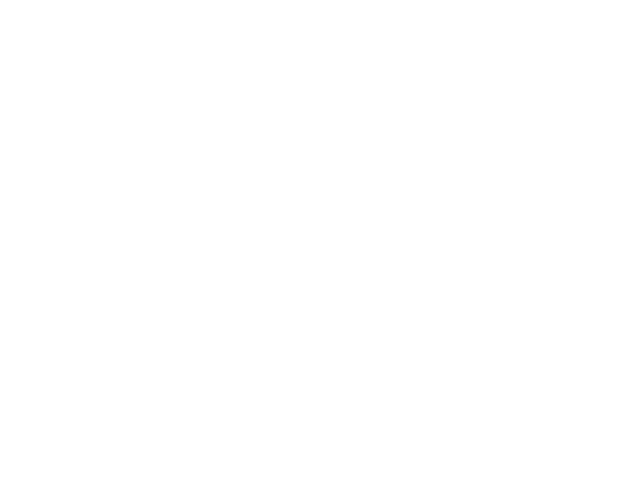

In [8]:
x = np.linspace(0, 3, 300)

y = (x>MIN_DIST) * np.exp(-x+MIN_DIST)
y[x<=MIN_DIST] = 1.0

function = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(function, x, y) 

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

x_p = np.arange(0,3,0.01)
y_p = np.exp(- (x_p-MIN_DIST) * ( (x_p - MIN_DIST) >=0 ) )
y_p2 = 1 / (1 + a*x_p**(2*b))

plt.figure()
plt.plot(x_p,y_p, label='Target')
plt.plot(x_p,y_p2, label='Fitted')

In [9]:
@numba.jit(nopython=True)
def clip(x,val=4.0):

    if x>val:
        return val
    elif x<-val:
        return -val
    else:
        return x
    
@numba.jit(nopython=True)
def update_attraction(x, y, a, b, dim, lr, P):
    dist = np.sum((x - y)**2)

    if dist>0.0:
        grad_coeff = 2*a*b*dist**(b-1.0) / (1 + a * dist**b)
    else:
        grad_coeff = 0.0


    for d in range(dim):
        mv = clip(grad_coeff * P * (x[0,d]-y[0,d]))  # * P[idx,idy]
        mv = mv * lr

        x[0,d] -= mv
        y[0,d] += mv
        
    return

@numba.jit(nopython=True)
def update_repulsion(x, y, a, b, dim, lr, P):
    dist = np.sum((x - y)**2)

    if dist>0.0:
        grad_coeff = 2 * repulsion_strength * b / ( (0.001+dist) * (1.0 + a * dist**b) )
    else:
        grad_coeff = 0


    for d in range(dim):
        #if grad_coeff > 0.0:
        #    grad = clip(grad_coeff  * (x[0,d]-y[0,d]))
        #    #* (1 - P[idx,idy])
        #else:
        #    grad = 0.0

        grad = clip(grad_coeff  * (x[0,d]-y[0,d]) * (1-P))
        mv = grad * lr

        x[0,d] += mv
        #y[0,d] -= mv

    
    
@numba.jit(nopython=True)
def one_step_in_a_set(emA, emH, idx, rows, columns, a, b, dim,
                   nA, n_points,
                   epochs_per_sample,
                   epoch_of_next_sample,
                   epochs_per_negative_sample,
                   epoch_of_next_negative_sample,
                   lr, epoch):
    
    if epoch_of_next_sample[idx] <= epoch:
        x_idx = rows[idx]
        y_idx = columns[idx]
        
        if x_idx < nA:
            x = emA[x_idx:x_idx+1,:]
        else:
            x = emH[x_idx-nA:x_idx-nA+1,:]
        
        if y_idx < nA:
            y = emA[y_idx:y_idx+1, :]
        else:
            y = emH[y_idx-nA:y_idx-nA+1,:]
            
        update_attraction(x, y, a, b, dim, lr, 1)
        
        epoch_of_next_sample[idx] += epochs_per_sample[idx]
        
        n_neg_samples = int(
                (epoch - epoch_of_next_negative_sample[idx]) / epochs_per_negative_sample[idx]
            )
        
        for i in range(n_neg_samples):
            y_idx = np.random.choice(n_points)
            
            if x_idx == y_idx:
                continue
            
            if y_idx < nA:
                y = emA[y_idx:y_idx+1, :]
            else:
                y = emH[y_idx-nA:y_idx-nA+1,:]
                
            update_repulsion(x, y, a, b, dim, lr, 0)
            
        epoch_of_next_negative_sample[idx] += (
                n_neg_samples * epochs_per_negative_sample[idx]
            )
            
            
            
    
    return 

@numba.jit(nopython=True, parallel=True)
def one_epoch_nsets(emCommon, embS,
                     rows, columns,
                     nCommon, n_points_,
                     Set, K_idx,
                     a, b, dim,
                     lr, epoch,
                     epochs_per_sample,
                     epoch_of_next_sample,
                     epochs_per_negative_sample,
                     epoch_of_next_negative_sample,
                     repulsion_strength=1.0):
    '''
    Set1 = 1 * np.ones(epochs_per_sample_1.shape[0])
    Set2 = 2 * np.ones(epochs_per_sample_2.shape[0])
    Set = np.random.permutation(np.concatenate((Set1,Set2)))
    '''
    
    for i in prange(len(Set)):
        idx = Set[i]
        one_step_in_a_set(emA=emCommon, emH=embS[idx], idx=K_idx[i], 
                              rows=rows[idx], columns=columns[idx], a=a, b=b, dim=dim,
                              nA=nCommon, n_points=n_points_[idx],
                              epochs_per_sample=epochs_per_sample[idx],
                              epoch_of_next_sample=epoch_of_next_sample[idx],
                              epochs_per_negative_sample=epochs_per_negative_sample[idx],
                              epoch_of_next_negative_sample=epoch_of_next_negative_sample[idx],
                              lr=lr, epoch=epoch)
    
    return 

from sklearn.decomposition import PCA

n_components = 2

pca = PCA(n_components = n_components)
init = pca.fit_transform(SETA)
embA = init.astype(np.float32).copy()
expansion = 10.0 / np.abs(embA).max()
embA = (embA * expansion).astype(np.float32)

emb_sets = []

print('before initi')

for i in range(n_SET):
    data = DATA[i]
    emb_i = pca.transform(data[nA:])
    emb_i = (emb_i * expansion).astype(np.float32)
    
    emb_sets.append(emb_i)
    
print('after init')

repulsion_strength=1.0

init_lr = 1.0

#SET_IDX
#K_IDX

print(len(EPOCH_OF_NEXT_NEGATIVE_SAMPLE))
print(EPOCH_OF_NEXT_NEGATIVE_SAMPLE[0].shape)

import timeit

for epoch in range(epochs):
    pass
    
    if epoch%20==0:
        print('epoch ', epoch, 'of ', epochs)
    #print('epoch ', epoch, 'of ', epochs)
    start = timeit.default_timer()
    
    lr = init_lr * (1.0 - float(epoch)/float(epochs))
    
    #'''
    one_epoch_nsets(emCommon=embA, embS=emb_sets,
                     rows=ROWS, columns=COLUMNS,
                     nCommon=nA, n_points_=N_DATA,
                     Set=SET_IDX, K_idx=K_IDX,
                     a=a, b=b, dim=n_components,
                     lr=lr, epoch=epoch,
                     epochs_per_sample=EPOCHS_PER_SAMPLE,
                     epoch_of_next_sample=EPOCH_OF_NEXT_SAMPLE,
                     epochs_per_negative_sample=EPOCHS_PER_NEGATIVE_SAMPLE,
                     epoch_of_next_negative_sample=EPOCH_OF_NEXT_NEGATIVE_SAMPLE,
                     repulsion_strength=repulsion_strength)
    #'''
    stop = timeit.default_timer()
    print('Time for epoch ', epoch, ': ', stop - start) 


before initi
after init
5
(620200,)
epoch  0 of  200


/home/ponir/pyTorch1.9/lib/python3.6/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'columns' of function 'one_epoch_nsets'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-9-228e208a093b>", line 109:
@numba.jit(nopython=True, parallel=True)
def one_epoch_nsets(emCommon, embS,
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/ponir/pyTorch1.9/lib/python3.6/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'embS' of function 'one_epoch_nsets'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

Time for epoch  0 :  4.507454822
Time for epoch  1 :  0.2121733169988147
Time for epoch  2 :  0.2855867890029913
Time for epoch  3 :  0.32407042200065916
Time for epoch  4 :  0.3701915880010347
Time for epoch  5 :  0.3825731100005214
Time for epoch  6 :  0.41303670199704356
Time for epoch  7 :  0.4285715110017918
Time for epoch  8 :  0.4463299319977523
Time for epoch  9 :  0.4618934640020598
Time for epoch  10 :  0.466613687996869
Time for epoch  11 :  0.4754052589996718
Time for epoch  12 :  0.49732896399655147
Time for epoch  13 :  0.48578871399513446
Time for epoch  14 :  0.49313954199897125
Time for epoch  15 :  0.48140050799702294
Time for epoch  16 :  0.4912447099995916
Time for epoch  17 :  0.49212590500246733
Time for epoch  18 :  0.48787928900128463
Time for epoch  19 :  0.49562658200011356
epoch  20 of  200
Time for epoch  20 :  0.4915368310030317
Time for epoch  21 :  0.48900741599936737
Time for epoch  22 :  0.49212085500039393
Time for epoch  23 :  0.4958200070032035
Time 

Time for epoch  194 :  0.49773505100165494
Time for epoch  195 :  0.506055969002773
Time for epoch  196 :  0.5068828639996354
Time for epoch  197 :  0.4983838359985384
Time for epoch  198 :  0.5100441190006677
Time for epoch  199 :  0.505059697003162


<IPython.core.display.Javascript object>


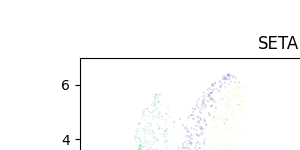

(3000, 2)


<IPython.core.display.Javascript object>


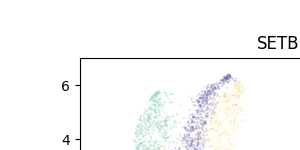

<IPython.core.display.Javascript object>


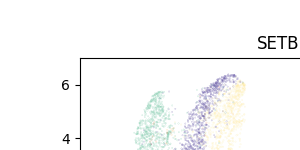

<IPython.core.display.Javascript object>


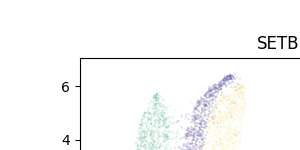

<IPython.core.display.Javascript object>


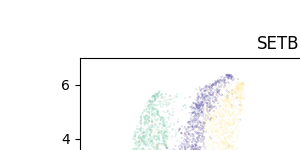

<IPython.core.display.Javascript object>


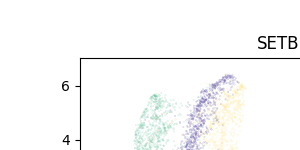

In [10]:
%matplotlib notebook

plt.figure()
plt.title('SETA')
print(embA.shape)
plt.scatter(embA[:,0], embA[:,1], c=y_SETA, s=0.01, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

for i in range(n_SET):

    plt.figure()
    plt.title('SETB')
    embB = emb_sets[i]
    y_embB = y_SETS[i]
    plt.scatter(embB[:,0], embB[:,1], c=y_embB, s=0.01, cmap='Spectral')
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(classes)




In [11]:
emb_sets_tuned = np.array(emb_sets)

with open('MNIST_Aligned_NE_5_SETS_3000_11400.npy', 'wb') as f:
    np.save(f, embA)
    np.save(f, emb_sets_tuned)